# Traning for SY 1.9 & 2.0

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import time
import os
import datetime
import glob
import csv

import torchvision
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset, random_split
from torchvision import transforms

import pandas as pd
import seaborn as sns

from numpy import genfromtxt

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## define functions

In [2]:
def plotSpec(seyfert,n):
    if seyfert == 1.9:
        plt.plot(np.linspace(3800,7500,7500-3800+1), sy19_feature[n].tolist())
    if seyfert == 2:
        plt.plot(np.linspace(3800,7500,7500-3800+1), sy2_feature[n].tolist())
        
def sizeMap(inputSize):
    C1 = (inputSize-50)+1
    S2 = int(C1/2)
    C3 = (S2-50)+1
    S4 = int(C3/2)
    return C1, S2, C3, S4


def read_data(filename, delimiter=','):
    with open(filename, 'r') as my_file:
        reader = csv.reader(my_file, delimiter=delimiter)
        my_list = list(reader)[0]
        my_list= [float(i) for i in my_list]
        return my_list

## read  data

In [3]:
# The feature size is 1x(7500-3800+1), a pixel to one wavelenght
# merge data in previouly defined in different files
sy19_feature_train = read_data('sy19-pixels-3800-7500-redshifted-normalized.csv', delimiter=',')
sy19_feature_test = read_data('sy19-test-pixels-3800-7500-redshifted-normalized.csv', delimiter=',')
sy20_feature_1 = read_data('sy20-pixels-3800-7500-redshifted-normalized.csv', delimiter=',')
sy20_feature_2 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.0.csv', delimiter=',')
sy20_feature_3 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.1.csv', delimiter=',')
sy20_feature_4 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.2.csv', delimiter=',')
sy20_feature_5 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.3.csv', delimiter=',')
sy20_feature_6 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.4.csv', delimiter=',')
sy20_feature_7 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.5.csv', delimiter=',')
sy20_feature_8 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.6.csv', delimiter=',')

In [4]:
# read sy19 with noise   
sy19_noise_feature_train = []
for file in glob.glob('sy19-pixels*noise*'):
    print('reading:', file)
    file_feature = read_data(file, delimiter=',')
    sy19_noise_feature_train = np.concatenate((sy19_noise_feature_train, file_feature), axis=0)

sy19_noise_feature_test = []
for file in glob.glob('sy19-test*noise*'):
    print('reading:', file)
    file_feature = read_data(file, delimiter=',')
    sy19_noise_feature_test = np.concatenate((sy19_noise_feature_test, file_feature), axis=0)

reading: sy19-pixels-3800-7500-redshifted-normalized-noise.0.csv
reading: sy19-pixels-3800-7500-redshifted-normalized-noise.1.csv
reading: sy19-pixels-3800-7500-redshifted-normalized-noise.2.csv
reading: sy19-pixels-3800-7500-redshifted-normalized-noise.3.csv
reading: sy19-pixels-3800-7500-redshifted-normalized-noise.4.csv
reading: sy19-pixels-3800-7500-redshifted-normalized-noise.5.csv
reading: sy19-pixels-3800-7500-redshifted-normalized-noise.6.csv
reading: sy19-pixels-3800-7500-redshifted-normalized-noise.7.csv
reading: sy19-pixels-3800-7500-redshifted-normalized-noise.8.csv
reading: sy19-pixels-3800-7500-redshifted-normalized-noise.9.csv
reading: sy19-test-pixels-3800-7500-redshifted-normalized-noise.0.csv
reading: sy19-test-pixels-3800-7500-redshifted-normalized-noise.1.csv
reading: sy19-test-pixels-3800-7500-redshifted-normalized-noise.2.csv
reading: sy19-test-pixels-3800-7500-redshifted-normalized-noise.3.csv
reading: sy19-test-pixels-3800-7500-redshifted-normalized-noise.4.csv


In [5]:
##  Small sample pre-traning
#sy19_feature = sy19_feature_1
#sy20_feature = sy20_feature_1

## Full sample
sy19_feature_train = np.concatenate((sy19_feature_train,  sy19_noise_feature_train), axis=0)
sy19_feature_test = np.concatenate((sy19_feature_test, sy19_noise_feature_test), axis=0)
sy20_feature = np.concatenate((sy20_feature_1, sy20_feature_2,sy20_feature_3,sy20_feature_4,\
                               sy20_feature_5,sy20_feature_6,sy20_feature_7,sy20_feature_8), axis=0)

sy19_feature_train = torch.Tensor(sy19_feature_train).view(-1,7500-3800+1)
sy19_feature_test = torch.Tensor(sy19_feature_test).view(-1,7500-3800+1)
sy20_feature = torch.Tensor(sy20_feature).view(-1,7500-3800+1)

In [6]:
print(len(sy19_feature_train),len(sy19_feature_test),len(sy20_feature))

3300 4895 8400


In [7]:
# classify 1.9 as 1, and 2 as 0. 
sy19_label_train = torch.ones(sy19_feature_train.size(0),dtype=torch.long)
sy19_label_test = torch.ones(sy19_feature_test.size(0),dtype=torch.long)
sy20_label = torch.zeros(sy20_feature.size(0),dtype=torch.long)

# create indices
sy19_indice_train = torch.linspace(0,len(sy19_feature_train)-1,len(sy19_feature_train)).int()
sy19_indice_test = torch.linspace(0,len(sy19_feature_test)-1,len(sy19_feature_test)).int()
sy20_indice = torch.linspace(0,len(sy20_feature)-1,len(sy20_feature)).int()

# taking same number of 1.9 and 2.0 seyfert galaxies
sy19_dataset_train = TensorDataset(sy19_indice_train,sy19_feature_train,sy19_label_train)
sy19_dataset_test = TensorDataset(sy19_indice_test,sy19_feature_test,sy19_label_test)

sy20_dataset_train = TensorDataset(sy20_indice[:len(sy19_dataset_train)],sy20_feature[:len(sy19_dataset_train)],sy20_label[:len(sy19_dataset_train)])
sy20_dataset_test = TensorDataset(sy20_indice[len(sy19_dataset_train):],sy20_feature[len(sy19_dataset_train):],sy20_label[len(sy19_dataset_train):])

# merge the test dataset
dataset = ConcatDataset((sy19_dataset_train,sy20_dataset_train))

In [ ]:
# split to train and test datasets
#train_ratio = 0.75
#train_size = int(train_ratio * len(sy19_dataset))
#test_size = len(sy19_dataset) - train_size

#sy19_train_dataset, sy19_test_dataset = random_split(sy19_dataset, [train_size, test_size])
#sy20_train_dataset, sy20_test_dataset = random_split(sy20_dataset, [train_size, test_size])

# merge the test dataset
#dataset = ConcatDataset((sy19_train_dataset,sy20_train_dataset))

In [ ]:
# merge data
#features = torch.cat((sy19_feature,sy20_feature[:len(sy19_feature)]),0)
#labels = torch.cat((sy19_label,sy20_label[:len(sy19_feature)]),0)
#indices = torch.cat((sy19_indice,sy20_indice[:len(sy19_feature)]),0)

## shuffle the dataset 
#dataset_rand = dataset[torch.randperm(len(dataset))]

## read test data

In [30]:
# The feature size is 1x(7500-3800+1), a pixel to one wavelenght
#sy19_test_feature = genfromtxt('sy19-test-pixels-3800-7500-redshifted-normalized.csv', delimiter=',')
#sy20_test_feature = genfromtxt('sy20-test-pixels-3800-7500-redshifted-normalized.0.csv', delimiter=',')
#
#sy19_test_feature = torch.Tensor(sy19_test_feature).view(-1,7500-3800+1)
#sy20_test_feature = torch.Tensor(sy20_test_feature).view(-1,7500-3800+1)

In [31]:
# classify 1.9 as 1, and 2 as 0. 
#sy19_test_label = torch.ones(sy19_test_feature.size(0),dtype=torch.long)
#sy20_test_label = torch.zeros(sy20_test_feature.size(0),dtype=torch.long)

# create indices
#sy19_test_indice = torch.linspace(0,len(sy19_test_feature)-1,len(sy19_test_feature)).int()
#sy20_test_indice = torch.linspace(0,len(sy20_test_feature)-1,len(sy20_test_feature)).int()

In [32]:
#sy19_test_dataset = TensorDataset(sy19_test_indice,sy19_test_feature,sy19_test_label)
#sy20_test_dataset = TensorDataset(sy20_test_indice,sy20_test_feature,sy20_test_label)

## CNN Network - One layer of Full CNN

### computing output size of image


- i = input
- o = output
- p = padding
- k = kernel_size
- s = stride
- d = dilation

o = [i + 2*p - k - (k-1)*(d-1)]/s + 1

In your case this gives o = [32 + 2 - 3 - 2*1]/1 +1 = [29] + 1 = 30.
Now, you could set all your parameters and “solve” the equation for p.
You will see, that p=2 will give you an output size of 32.

You could  with some tools like ezyang’s convolution visualizer 308 or calculate it with this formula:
https://ezyang.github.io/convolution-visualizer/index.html



###  Network Map

| Layer | Type | Maps | Kernel_size | Padding | Stride | Image_size | Activation | Comment |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
|  Out | Linear | - | - | - | - | 2 | - |  |
|  F7 | Linear | - | - | - | - | 100 | ReLU | 1000 -> 100  |
|  D6 | Dropout (0.5) | - | - | - | - | - | - | - |
|  C5 | Convolution | 1000 | 888 | 0 | 1 | 1 | ReLU |  |
|  S4 | Avg Pooling | 128 | 2 | 0 | 2 | 888 | - |  |
|  C3 | Convolution | 128 | 50 | 0 | 1 | 1777 | ReLU |  |
|  S2 | Avg Pooling | 64 | 2 | 0 | 2 | 1826 | - |  |
|  C1 | Convolution | 64 | 50 | 0 | 1 | 3652 | ReLU |  |
| In | Input | 1 | - | - |- | 3701 |- | |

In [50]:
import sys
sys.path.append('../')
from pycore.tikzeng import *

# defined your arch
arch = [
    to_head( '..' ),
    to_cor(),
    to_begin(),
    to_Conv("conv1", 512, 64, offset="(0,0,0)", to="(0,0,0)", height=64, depth=64, width=2 ),
    to_Pool("pool1", offset="(0,0,0)", to="(conv1-east)"),
    to_Conv("conv2", 128, 64, offset="(1,0,0)", to="(pool1-east)", height=32, depth=32, width=2 ),
    to_connection( "pool1", "conv2"),
    to_Pool("pool2", offset="(0,0,0)", to="(conv2-east)", height=28, depth=28, width=1),
    to_SoftMax("soft1", 10 ,"(3,0,0)", "(pool1-east)", caption="SOFT"  ),
    to_connection("pool2", "soft1"),
    to_end()
    ]

def main():
    namefile = str(sys.argv[0]).split('.')[0]
    to_generate(arch, namefile + '.tex' )

if __name__ == '__main__':
    main()

ModuleNotFoundError: No module named 'pycore.tikzeng'

In [11]:
sizeMap(3701)

(3652, 1826, 1777, 888)

In [11]:
class simpleCNN(nn.Module):
    
    def __init__(self):
        super(simpleCNN, self).__init__()
        self.C1 = nn.Conv1d(1, 64, 50)
        self.S2 = nn.AvgPool1d(2, stride=2)
        self.C3 = nn.Conv1d(64, 128, 50)
        self.S4 = nn.AvgPool1d(2, stride=2)
        self.C5 = nn.Conv1d(128, 1000, 888)
        self.D6 = nn.Dropout(0.5)
        self.F7 = nn.Linear(1000, 100)
        self.Out= nn.Linear(100, 2)
        
    def forward(self, x):
        x = F.relu(self.C1(x),inplace=True)
        x = self.S2(x)
        x = F.relu(self.C3(x),inplace=True)
        x = self.S4(x)
        x = F.relu(self.C5(x),inplace=True)
        x = self.D6(x)
        x = x.view(x.size(0),-1)
        x = F.relu(self.F7(x),inplace=True)
        x = self.Out(x)
        return x

In [12]:
net = simpleCNN()
print(net)

simpleCNN(
  (C1): Conv1d(1, 64, kernel_size=(50,), stride=(1,))
  (S2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (C3): Conv1d(64, 128, kernel_size=(50,), stride=(1,))
  (S4): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (C5): Conv1d(128, 1000, kernel_size=(888,), stride=(1,))
  (D6): Dropout(p=0.5, inplace=False)
  (F7): Linear(in_features=1000, out_features=100, bias=True)
  (Out): Linear(in_features=100, out_features=2, bias=True)
)


In [13]:
## Test
x = torch.randn(5,1,3701)
net(x)

tensor([[-0.0445,  0.0507],
        [-0.0544,  0.0496],
        [-0.0737,  0.0424],
        [-0.0473,  0.0306],
        [-0.0813,  0.0450]], grad_fn=<AddmmBackward>)

### Check GPU availabel

In [25]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    net.cuda(0)
    device = torch.device('cuda:0')
    print ('USE GPU')
else:
    device = torch.device('cpu')
    print ('USE CPU')

USE GPU


### define optimizer, loss function and accuracy 

In [32]:
learning_rate = 0.001

loss = nn.CrossEntropyLoss() # 包含了softmax 和 cross entropy
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas=(0.9,0.999), eps=1e-8)
#optimizer = optim.SGD(net.parameters(), lr=learning_rate)

In [21]:
def accuracy(y_hat, y):
#    y_hat = torch.sign(y_hat)
    return (y_hat.argmax(dim=1) == y).float().mean().item()

def evaluate_accuracy(data_iter, net, device):
    acc = torch.tensor([0.0], device=device)
    for (index, img, label) in data_iter:
        img = img.view(-1,1,3701)
        # 如果 device 是 GPU，将数据复制到 GPU 上。
        if use_gpu:
            index, img, label = index.to(device), img.to(device), label.to(device)
        acc += accuracy(net(img), label)
    return acc.item() / len(data_iter)

### TRAINING

In [17]:
##original saved file with DataParallel
#state_dict = torch.load('./cuda3.pt')
#
### create new OrderedDict that does not contain module.
#from collections import OrderedDict
#new_state_dict = OrderedDict()
#
#for k, v in state_dict.items():
#    name = k[7:] # remove module.
#    new_state_dict[name] = v
#
### load params
#net.load_state_dict(new_state_dict)
#
#net.load_state_dict(torch.load('./cuda3.pt'))

In [27]:
num_epochs = 500

batch_size = 50
train_iter = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [44]:
## laod previous traning results
#
#net.load_state_dict(torch.load('cuda3-GOOD.pt'))
#
#previous = pd.read_csv('./runs/acc-list-cuda3-2019-07-22-15-02-10-826651-GOOD.csv', header=0, comment='#')
#
#loss_list = list(previous['loss'])
#sy19_test_acc_list = list(previous['sy19_test_acc'])
#sy20_test_acc_list = list(previous['sy20_test_acc'])
#train_acc_list = list(previous['train_acc'])

In [23]:
sy19_test_acc_list = []
sy20_test_acc_list = []
train_acc_list = []
loss_list = []

In [ ]:
for epoch in range(num_epochs):
    net.train() 
    start = time.time()
    train_l_sum = 0.
    train_acc_sum = 0.
    for (index, img, label) in train_iter:
        img = img.view(-1,1,3701)
        if use_gpu:
            index, img, label = index.to(device), img.to(device), label.to(device)
        optimizer.zero_grad()
        predict = net(img)
        l = loss(predict, label.view(-1))
        l.backward()
        optimizer.step()
        train_l_sum += l.data.item()
        train_acc_sum += accuracy(predict, label.view(-1))
        #print(l)
    
    if ((epoch+1)%1 ==0):
        net.eval() 
        sy19_test_iter = DataLoader(sy19_dataset_test, batch_size=batch_size, shuffle=True, num_workers=4)
        sy19_test_acc = evaluate_accuracy(sy19_test_iter, net, device)
        sy20_test_iter = DataLoader(sy20_dataset_test, batch_size=batch_size, shuffle=True, num_workers=4)
        sy20_test_acc = evaluate_accuracy(sy20_test_iter, net, device)
        
        print('epoch %d, loss %.6f, train acc %.6f, sy19 test acc  %.4f, sy20 test acc  %.4f, '
                'time %.1f sec' % (epoch + 1, train_l_sum / len(train_iter),
                                    train_acc_sum / len(train_iter),
                                    sy19_test_acc, sy20_test_acc, time.time() - start))
        sy19_test_acc_list.append(sy19_test_acc)
        sy20_test_acc_list.append(sy20_test_acc)
        loss_list.append(train_l_sum / len(train_iter))
        train_acc_list.append(train_acc_sum / len(train_iter))

In [46]:
## save results
acc_lists = pd.DataFrame({'loss': loss_list, 'train_acc':train_acc_list, 'sy19_test_acc': sy19_test_acc_list, 'sy20_test_acc': sy20_test_acc_list})
acc_lists_filename = 'acc-list-cuda0-'+str(datetime.datetime.now()).replace(' ','-').replace(':','-').replace('.','-')+'.csv'
acc_lists.to_csv('./runs/'+acc_lists_filename)
print(acc_lists_filename)

model_filename = './runs/'+'model-cuda0-'+str(datetime.datetime.now()).replace(' ','-').replace(':','-').replace('.','-')+'.pt'
torch.save(net.state_dict(), 'model_filename')

acc-list-cuda0-2019-11-17-19-05-57-973592.csv


(-0.02, 1.05)

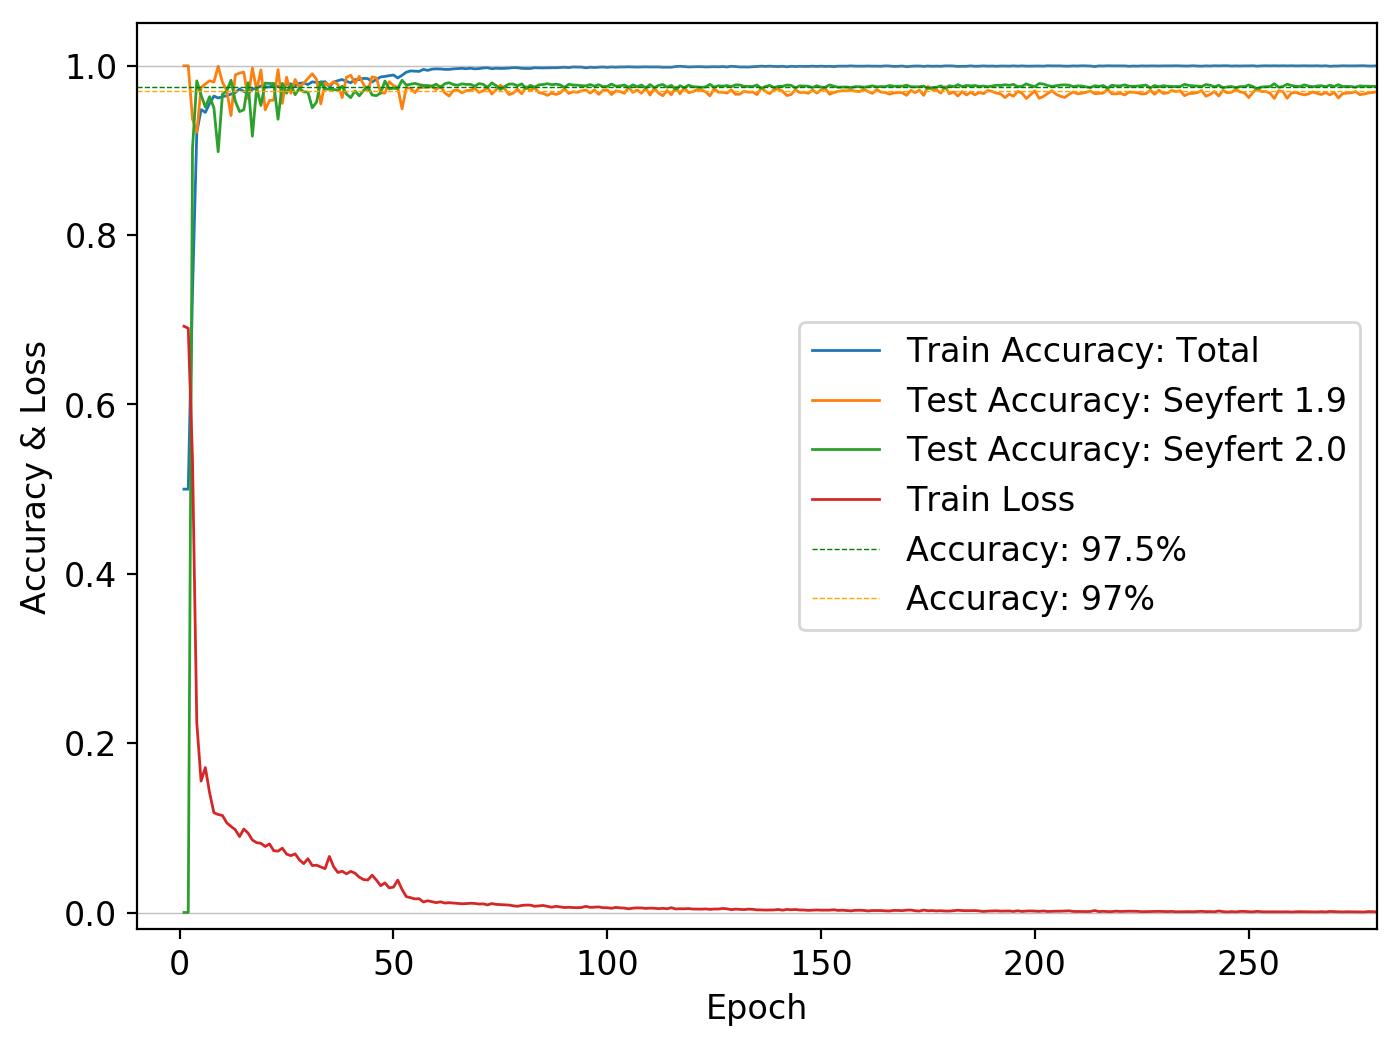

In [45]:
epoches = np.linspace(1,len(loss_list),len(loss_list))
plt.plot(epoches, train_acc_list, '-', linewidth=1,label='Train Accuracy: Total')
plt.plot(epoches, sy19_test_acc_list, '-', linewidth=1,label='Test Accuracy: Seyfert 1.9')
plt.plot(epoches, sy20_test_acc_list, '-', linewidth=1,label='Test Accuracy: Seyfert 2.0')
plt.plot(epoches, loss_list,'-', linewidth=1,label='Train Loss')


plt.axhline(y=1.0,color='grey',linestyle='solid',linewidth=0.5, alpha=0.5, label='')
plt.axhline(y=0.975,color='green',linestyle='dashed',linewidth=0.5,  label='Accuracy: 97.5%')
plt.axhline(y=0.97,color='orange',linestyle='dashed',linewidth=0.5,  label='Accuracy: 97%')
plt.axhline(y=0,color='grey',linestyle='solid',linewidth=0.5,  alpha=0.5, label='')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy & Loss')

plt.xlim(-10,280)
plt.ylim(-0.02,1.05)

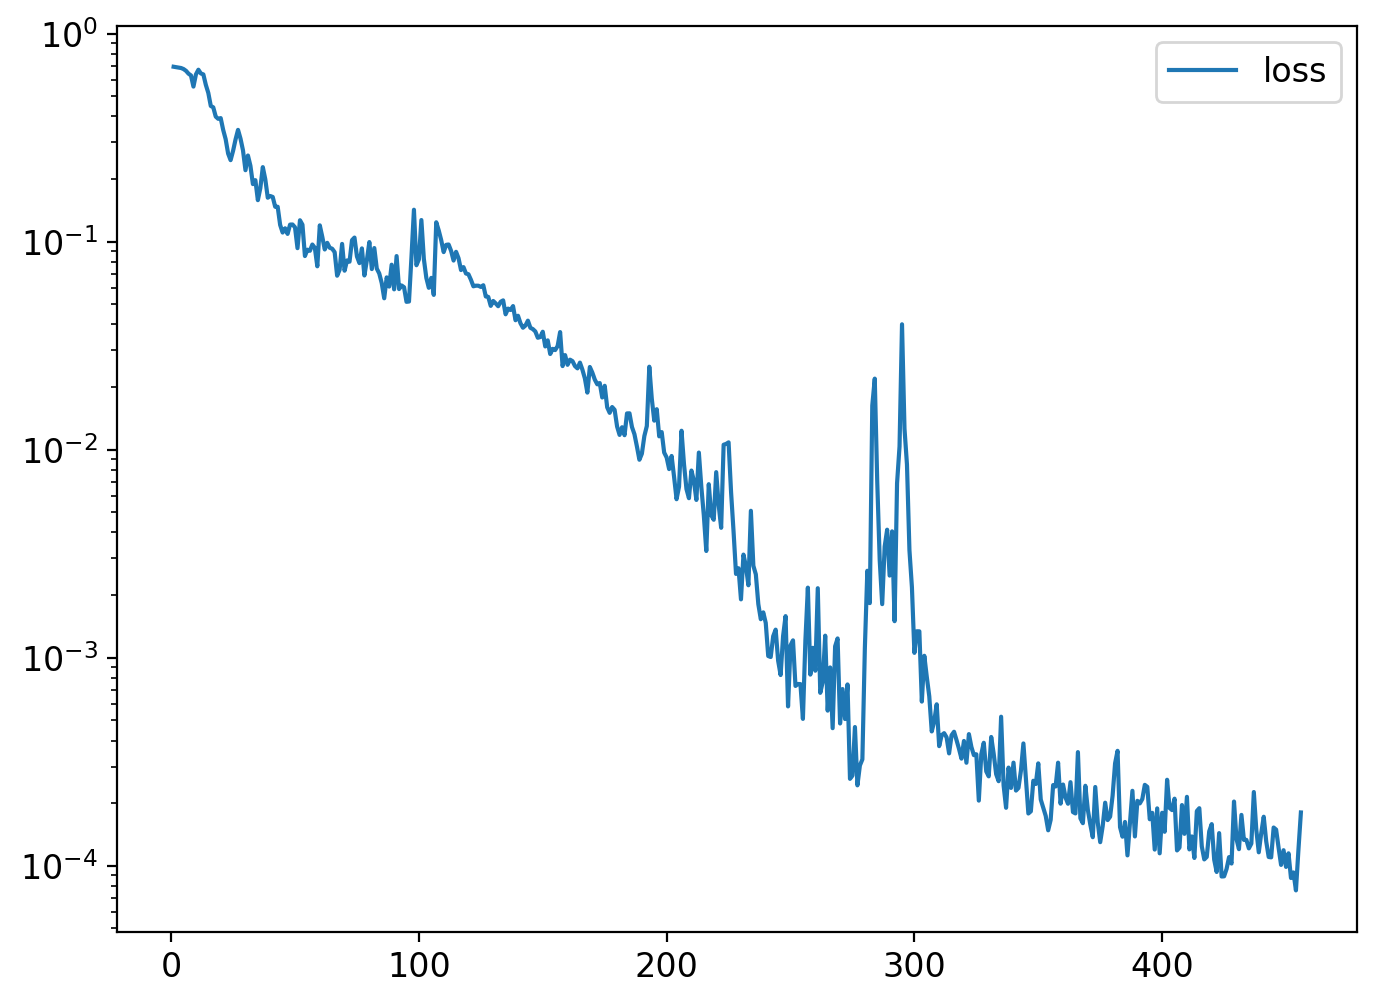

In [112]:
plt.semilogy(epoches, loss_list,label='loss')
plt.legend()